# Performing Fuzzy Table Joins

## Overview

This tutorial shows how to use GeoPandas to do a fuzzy table join. We will be covering advanced data cleaning techniques to be able to merge datasets from different sources.

We will be working with 2 data layers for the Sri Lanka. Given the shapefile of Admin4 regions and a CSV file containing division-wise population statistics - we will learn how to merge them to display these indicators on a map.

Input Layers:
* `lka_admbnda_adm4_slsd_20220816.shp`: A shapefile of all Grama Niladhari (GN)Divisions (Admin Level 4) of Sri Lanka.
* `GN_Division_Age_Group_of_Population.csv`: Age-wise population for all GN Divisions of Sri Lanka.

Output:
* `srilanka.gpkg`: A geopackage containing merged dataset.

Data Credit: 
* Sri Lanka Population Statistics: Department of Census and Statistics - Sri Lanka.  Downloaded from DCS Map Portal](http://map.statistics.gov.lk/).
* Sri Lanka - Subnational Administrative Boundaries: Sri Lanka administrative levels 0-4 shapefiles and gazetteer. Downloaded from [HDX portal](https://data.humdata.org/dataset/cod-ab-lka).

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
try:
    import geopandas
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        !apt install libspatialindex-dev -qq
        !pip install fiona shapely pyproj rtree --quiet
        !pip install geopandas --quiet
        !pip install thefuzz
    else:
        print('geopandas not found, please install via conda in your environment')

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from thefuzz import process

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/srilanka/'

shapefile = 'lka_admbnda_adm4_slsd_20220816'
exts = ['.shp', '.shx', '.dbf', '.prj']
csv_file = 'GN_Division_Age_Group_of_Population.csv'

for ext in exts:
  download(data_url + shapefile + ext)

download(data_url + csv_file)

## Procedure

### Pre-Process Data Table

The data table containing population couts is organized by 1 row per GN Division. We do not have a unique identifier that uniquely matches a GN Division. Since GN Division names are not unique amounf different provinces, we must create a unique identifier to be able to match it against another data source.

In [5]:
csv_path = os.path.join(data_folder, csv_file)
df = pd.read_csv(csv_path)
df

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above
0,Sammanthranapura,Colombo,Colombo,Western,7829,1604,1373,1262,1251,944,796,400,131,52,16
1,Mattakkuliya,Colombo,Colombo,Western,28003,4932,4738,4379,4220,3702,2920,1944,834,239,95
2,Modara,Colombo,Colombo,Western,17757,3045,2791,3101,2688,2321,1872,1271,481,159,28
3,Madampitiya,Colombo,Colombo,Western,12970,2834,2415,2066,1940,1687,1147,581,238,52,10
4,Mahawatta,Colombo,Colombo,Western,8809,1529,1495,1406,1357,1198,953,555,213,75,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13984,Demeda,Deraniyagala,Kegalle,Sabaragamuwa,971,181,156,138,150,117,93,90,35,10,1
13985,Kosgahakanda,Deraniyagala,Kegalle,Sabaragamuwa,2336,360,364,343,331,295,293,216,107,26,1
13986,Yatiwala,Deraniyagala,Kegalle,Sabaragamuwa,1882,324,268,342,249,248,210,154,67,17,3
13987,Magala,Deraniyagala,Kegalle,Sabaragamuwa,1076,158,131,147,182,131,135,108,67,17,0


GN Division names are not unique, so they can't be used as identifiers for a join.

In [6]:
df[df['GN Division'].duplicated(keep=False)].sort_values('GN Division')

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above
8944,Abakolawewa North,Ambanpola,Kurunegala,North Western,561,100,81,81,83,83,72,37,17,7,0
6521,Abakolawewa North,Weeraketiya,Hambantota,Southern,648,131,114,93,84,85,65,37,25,11,3
8954,Abakolawewa South,Ambanpola,Kurunegala,North Western,488,72,77,67,62,70,72,43,16,8,1
6520,Abakolawewa South,Weeraketiya,Hambantota,Southern,322,62,47,39,40,46,41,29,11,6,1
6303,Abhayapura,Lunugamvehera,Hambantota,Southern,624,123,87,98,120,46,71,59,11,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Yatiyana East,Agalawatta,Kalutara,Western,1493,214,226,211,222,207,156,128,79,39,11
978,Yatiyana East,Minuwangoda,Gampaha,Western,2004,324,335,269,317,299,231,152,45,25,7
13634,Yodhagama,Aranayaka,Kegalle,Sabaragamuwa,760,129,124,88,99,108,99,67,35,9,2
13493,Yodhagama,Rambukkana,Kegalle,Sabaragamuwa,1421,259,223,182,204,206,168,122,41,13,3


Let's create a unique idenfier by merging the Admin4, Admin3, Admin2 and Admin1 names. We also remove  whitespaces and convert the names to lowercase to ensure the match is case insensitive.

In [7]:
df_processed = df.copy()
gn_division = df_processed['GN Division'].str.lower().str.replace(' ', '')
ds_division = df_processed['DS Division'].str.lower().str.replace(' ', '')
district = df_processed['District'].str.lower().str.replace(' ', '')
province = df_processed['Province'].str.lower().str.replace(' ', '')

df_processed['joinkey'] = gn_division + ds_division + district + province
df_processed

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above,joinkey
0,Sammanthranapura,Colombo,Colombo,Western,7829,1604,1373,1262,1251,944,796,400,131,52,16,sammanthranapuracolombocolombowestern
1,Mattakkuliya,Colombo,Colombo,Western,28003,4932,4738,4379,4220,3702,2920,1944,834,239,95,mattakkuliyacolombocolombowestern
2,Modara,Colombo,Colombo,Western,17757,3045,2791,3101,2688,2321,1872,1271,481,159,28,modaracolombocolombowestern
3,Madampitiya,Colombo,Colombo,Western,12970,2834,2415,2066,1940,1687,1147,581,238,52,10,madampitiyacolombocolombowestern
4,Mahawatta,Colombo,Colombo,Western,8809,1529,1495,1406,1357,1198,953,555,213,75,28,mahawattacolombocolombowestern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13984,Demeda,Deraniyagala,Kegalle,Sabaragamuwa,971,181,156,138,150,117,93,90,35,10,1,demedaderaniyagalakegallesabaragamuwa
13985,Kosgahakanda,Deraniyagala,Kegalle,Sabaragamuwa,2336,360,364,343,331,295,293,216,107,26,1,kosgahakandaderaniyagalakegallesabaragamuwa
13986,Yatiwala,Deraniyagala,Kegalle,Sabaragamuwa,1882,324,268,342,249,248,210,154,67,17,3,yatiwaladeraniyagalakegallesabaragamuwa
13987,Magala,Deraniyagala,Kegalle,Sabaragamuwa,1076,158,131,147,182,131,135,108,67,17,0,magaladeraniyagalakegallesabaragamuwa


We still have some duplicates. 

In [8]:
duplicate_df = df_processed[df_processed.duplicated('joinkey', keep=False)].sort_values('joinkey')
duplicate_df

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above,joinkey
10341,Ahugoda West,Polgahawela,Kurunegala,North Western,533,82,82,55,78,90,64,48,23,8,3,ahugodawestpolgahawelakurunegalanorthwestern
10335,Ahugoda West,Polgahawela,Kurunegala,North Western,876,153,134,115,140,111,97,79,33,14,0,ahugodawestpolgahawelakurunegalanorthwestern
10694,Aluthwatta,Chilaw,Puttalam,North Western,1350,179,238,188,186,187,162,139,54,17,0,aluthwattachilawputtalamnorthwestern
10693,Aluthwatta,Chilaw,Puttalam,North Western,1582,247,250,222,274,188,187,145,57,12,0,aluthwattachilawputtalamnorthwestern
2781,Dewahandiya East,Udadumbara,Kandy,Central,224,38,34,33,29,40,28,12,7,3,0,dewahandiyaeastudadumbarakandycentral
2793,Dewahandiya East,Udadumbara,Kandy,Central,378,58,65,50,48,49,57,32,12,6,1,dewahandiyaeastudadumbarakandycentral
2481,Gorakadoowa,Walallavita,Kalutara,Western,938,147,139,128,131,121,99,95,59,14,5,gorakadoowawalallavitakalutarawestern
2487,Gorakadoowa,Walallavita,Kalutara,Western,1624,288,279,244,252,195,186,107,43,23,7,gorakadoowawalallavitakalutarawestern
699,Halpe,Divulapitiya,Gampaha,Western,2219,356,361,336,356,317,227,169,66,25,6,halpedivulapitiyagampahawestern
757,Halpe,Divulapitiya,Gampaha,Western,2559,450,373,335,455,330,302,179,98,30,7,halpedivulapitiyagampahawestern


Since these refer to the same region, we merge the data for duplicate admin4 regions. While merging the rows, we sum the population counts from each row having the same key.

In [9]:
df_processed.columns

Index(['GN Division', 'DS Division', 'District', 'Province',
       'Total Population', 'Less than 10', '10 ~ 19', '20 ~ 29', '30 ~ 39',
       '40 ~ 49', '50 ~ 59', '60 ~ 69', '70 ~ 79', '80 ~ 89', '90 and above',
       'joinkey'],
      dtype='object')

In [10]:
df_dissolved = df_processed.groupby(['joinkey'],as_index=False).agg({
    'GN Division': 'first',
    'DS Division': 'first',
    'District': 'first',
    'Province': 'first',
    'Total Population': sum,
    'Less than 10': sum,
    '10 ~ 19': sum,
    '20 ~ 29': sum,
    '30 ~ 39': sum,
    '40 ~ 49': sum,
    '50 ~ 59': sum,
    '60 ~ 69': sum,
    '70 ~ 79': sum,
    '80 ~ 89': sum,
    '90 and above': sum
})
df_dissolved = df_dissolved[['joinkey', 'Total Population', 'Less than 10',
                             '10 ~ 19', '20 ~ 29', '30 ~ 39','40 ~ 49',
                             '50 ~ 59', '60 ~ 69', '70 ~ 79', '80 ~ 89',
                             '90 and above']]

In [11]:
print('Total Records of original table', len(df))
print('Total Records of processed table', len(df_dissolved))

Total Records of original table 13989
Total Records of processed table 13973


### Pre-Process Shapefile

Our shapefile comes from a different source and thus has a different structure. We need to match each feature with a record from the data table. We process the data to create a similar 'joinkey' and remove duplicates.

In [12]:
shapefile_path = os.path.join(data_folder, shapefile + '.shp')
gdf = gpd.read_file(shapefile_path, encoding='utf-8')
gdf

,Shape_Leng,Shape_Area,ADM4_EN,ADM4_SI,ADM4_TA,ADM4_PCODE,ADM4_REF,ADM3_EN,ADM3_SI,ADM3_TA,...,ADM1_TA,ADM1_PCODE,ADM0_EN,ADM0_SI,ADM0_TA,ADM0_PCODE,date,validOn,validTo,geometry
0,0.019689,0.000015,Sammanthranapura,සම්මන්ත්‍රණපුර,None,LK1103005,None,Colombo,කොළඹ,கொழும்பு,...,மேல் மாகாணம்,LK1,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.88040 6.98093, 79.88032 6.98062, ..."
1,0.072878,0.000177,Mattakkuliya,මට්ටක්කුලිය,None,LK1103010,None,Colombo,කොළඹ,கொழும்பு,...,மேல் மாகாணம்,LK1,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.88217 6.97996, 79.88218 6.97995, ..."
2,0.052290,0.000064,Modara,මෝදර,None,LK1103015,None,Colombo,කොළඹ,கொழும்பு,...,மேல் மாகாணம்,LK1,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.87507 6.96483, 79.87504 6.96479, ..."
3,0.019201,0.000023,Madampitiya,මාදම්පිටිය,None,LK1103020,None,Colombo,කොළඹ,கொழும்பு,...,மேல் மாகாணம்,LK1,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.87852 6.96328, 79.87849 6.96314, ..."
4,0.033889,0.000042,Mahawatta,මහවත්ත,None,LK1103025,None,Colombo,කොළඹ,கொழும்பு,...,மேல் மாகாணம்,LK1,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.87252 6.96160, 79.87261 6.96151, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,0.149196,0.000260,Demeda,දෙමැද,None,LK9233110,None,Deraniyagala,දැරණියගල,தெரனியாகலை,...,சபரகமுவ மாகாணம்,LK9,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.35891 6.87436, 80.35961 6.87238, ..."
14039,0.143733,0.000765,Kosgahakanda,කොස්ගහකන්ද,None,LK9233115,None,Deraniyagala,දැරණියගල,தெரனியாகலை,...,சபரகமுவ மாகாணம்,LK9,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.37824 6.89164, 80.37861 6.89139, ..."
14040,0.122895,0.000583,Yatiwala,යටිවල,None,LK9233120,None,Deraniyagala,දැරණියගල,தெரனியாகலை,...,சபரகமுவ மாகாணம்,LK9,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.40891 6.87830, 80.40845 6.87784, ..."
14041,0.246448,0.001756,Magala,මාගල,None,LK9233125,None,Deraniyagala,දැරණියගල,தெரனியாகலை,...,சபரகமுவ மாகாணம்,LK9,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.41601 6.88094, 80.41600 6.88093, ..."


In [13]:
gdf_processed = gdf.copy()
gdf_processed = gdf_processed.rename(columns = {
    'ADM4_EN': 'GN Division',
    'ADM3_EN': 'DS Division',
    'ADM2_EN': 'District',
    'ADM1_EN': 'Province'})

gn_division = gdf_processed['GN Division'].str.lower().str.replace(' ', '')
ds_division = gdf_processed['DS Division'].str.lower().str.replace(' ', '')
district = gdf_processed['District'].str.lower().str.replace(' ', '')
province = gdf_processed['Province'].str.lower().str.replace(' ', '')

gdf_processed['joinkey'] = gn_division + ds_division + district + province
gdf_processed = gdf_processed[['GN Division', 'DS Division', 'District', 'Province', 'joinkey', 'geometry']]
gdf_processed

,GN Division,DS Division,District,Province,joinkey,geometry
0,Sammanthranapura,Colombo,Colombo,Western,sammanthranapuracolombocolombowestern,"POLYGON ((79.88040 6.98093, 79.88032 6.98062, ..."
1,Mattakkuliya,Colombo,Colombo,Western,mattakkuliyacolombocolombowestern,"POLYGON ((79.88217 6.97996, 79.88218 6.97995, ..."
2,Modara,Colombo,Colombo,Western,modaracolombocolombowestern,"POLYGON ((79.87507 6.96483, 79.87504 6.96479, ..."
3,Madampitiya,Colombo,Colombo,Western,madampitiyacolombocolombowestern,"POLYGON ((79.87852 6.96328, 79.87849 6.96314, ..."
4,Mahawatta,Colombo,Colombo,Western,mahawattacolombocolombowestern,"POLYGON ((79.87252 6.96160, 79.87261 6.96151, ..."
...,...,...,...,...,...,...
14038,Demeda,Deraniyagala,Kegalle,Sabaragamuwa,demedaderaniyagalakegallesabaragamuwa,"POLYGON ((80.35891 6.87436, 80.35961 6.87238, ..."
14039,Kosgahakanda,Deraniyagala,Kegalle,Sabaragamuwa,kosgahakandaderaniyagalakegallesabaragamuwa,"POLYGON ((80.37824 6.89164, 80.37861 6.89139, ..."
14040,Yatiwala,Deraniyagala,Kegalle,Sabaragamuwa,yatiwaladeraniyagalakegallesabaragamuwa,"POLYGON ((80.40891 6.87830, 80.40845 6.87784, ..."
14041,Magala,Deraniyagala,Kegalle,Sabaragamuwa,magaladeraniyagalakegallesabaragamuwa,"POLYGON ((80.41601 6.88094, 80.41600 6.88093, ..."


There are some duplicate polygons having the same 'joinkey'.

In [14]:
duplicate_gdf = gdf_processed[gdf_processed.duplicated('joinkey', keep=False)].sort_values('joinkey')
duplicate_gdf

,GN Division,DS Division,District,Province,joinkey,geometry
7879,[unknown],Eravur Pattu,Batticaloa,Eastern,[unknown]eravurpattubatticaloaeastern,"POLYGON ((81.59942 7.77887, 81.59955 7.77876, ..."
7877,[unknown],Eravur Pattu,Batticaloa,Eastern,[unknown]eravurpattubatticaloaeastern,"POLYGON ((81.62471 7.78231, 81.62462 7.78238, ..."
7876,[unknown],Eravur Pattu,Batticaloa,Eastern,[unknown]eravurpattubatticaloaeastern,"POLYGON ((81.60296 7.78297, 81.60295 7.78290, ..."
7875,[unknown],Eravur Pattu,Batticaloa,Eastern,[unknown]eravurpattubatticaloaeastern,"POLYGON ((81.60157 7.78693, 81.60159 7.78693, ..."
7838,[unknown],Eravur Pattu,Batticaloa,Eastern,[unknown]eravurpattubatticaloaeastern,"POLYGON ((81.60935 7.79416, 81.60937 7.79408, ..."
...,...,...,...,...,...,...
2455,Miriswatta,Walallawita,Kalutara,Western,miriswattawalallawitakalutarawestern,"POLYGON ((80.09314 6.43583, 80.09315 6.43582, ..."
1389,Sapugasthenna,Attanagalla,Gampaha,Western,sapugasthennaattanagallagampahawestern,"POLYGON ((80.17102 7.10247, 80.17166 7.10118, ..."
1334,Sapugasthenna,Attanagalla,Gampaha,Western,sapugasthennaattanagallagampahawestern,"POLYGON ((80.04911 7.12307, 80.04923 7.12303, ..."
10612,Udappuwa,Mundel,Puttalam,North Western,udappuwamundelputtalamnorthwestern,"POLYGON ((79.79870 7.74958, 79.79863 7.74951, ..."


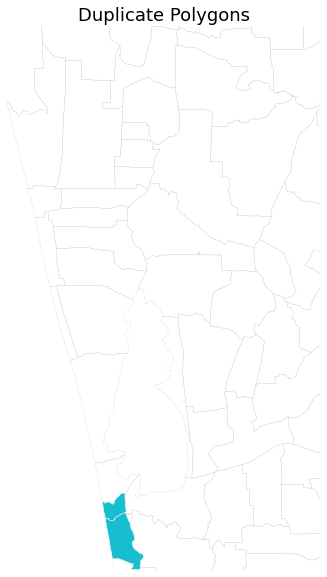

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)

# Plot all features and highlight duplicates
gdf_processed.plot(ax=ax, facecolor='none', edgecolor='#bdbdbd', linewidth=0.2)
duplicate_gdf.plot('joinkey', ax=ax, categorical=True, edgecolor='#ffffff', linewidth=0.5)

# Zoom to a specific region
selected = gdf_processed[gdf_processed['DS Division'] == 'Mundel']
minx, miny, maxx, maxy = selected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_axis_off()
ax.set_title('Duplicate Polygons', size = 18)

plt.show()

We dissolve (merge) these polygon boundaries to create a single region from multiple polygons having the same attributes.

In [17]:
gdf_dissolved = gdf_processed.dissolve(by='joinkey', aggfunc={
    'GN Division': 'first',
    'DS Division': 'first',
    'District': 'first',
    'Province': 'first'})
gdf_dissolved = gdf_dissolved.reset_index()

In [18]:
print('Total Records of original shapefile', len(gdf))
print('Total Records of processed shapefile', len(gdf_dissolved))

Total Records of original shapefile 14043
Total Records of processed shapefile 13987


### Table Join

Finally, we do a table join using GeoPandas merge().

We have almost equal count of features between the shapefile and table now. There are still a few polygons that do not have corresponding population counts. They will be removed from the output layer.

In [19]:
print('Total Records of processed shapefile', len(gdf_dissolved))
print('Total Records of processed table', len(df_dissolved))

Total Records of processed shapefile 13987
Total Records of processed table 13973


In [20]:
merged = gdf_dissolved.merge(df_dissolved, on='joinkey')

In [21]:
print('Total Records of merged shapefile', len(merged))

Total Records of merged shapefile 10747


There are still many records that do not have an exact match between the shapefile and the population table. This is due to small differences in their spellings. We can instead try a fuzzy match.

### Fuzzy Join

We use the fuzzy matching package [TheFuzz](https://github.com/seatgeek/thefuzz) (formerly FuzzyWuzzy) to find the closest match to each record.

Fuzzy matching for large tables can take long time, so we use `tqdm` package to track the progress.

In [22]:
gdf_dissolved.rename(columns = {'joinkey':'joinkey_exact'}, inplace=True)

In [23]:
from tqdm import tqdm

def getFuzzyMatch(row):
    joinkey = row['joinkey_exact']
    results = process.extractOne(joinkey, df_dissolved.joinkey)
    match = results[0]
    score = results[1]
    return match, score

tqdm.pandas()
gdf_dissolved[['match', 'score']] = gdf_dissolved.progress_apply(
    getFuzzyMatch, axis=1, result_type='expand')

100%|███████████████████████████████████| 13987/13987 [7:37:11<00:00,  1.96s/it]


The matches with scores less than 100 are fuzzy matches. 

In [24]:
gdf_dissolved[gdf_dissolved['score'] != 100][['joinkey_exact', 'match', 'score']].sort_values('score', ascending=False)

,joinkey_exact,match,score
0,041/2kanuwarajanganayaanuradhapuranorthcentral,41/2kanuwarajanganayaanuradhapuranorthcentral,99
10708,puthukudiyiruppuwestputhukkudiyiruppumullaitiv...,puthukkudiyiruppuwestputhukkudiyiruppumullaiti...,99
3936,hingurakgodahigurakgodapolonnaruwanorthcentral,hingurakgodahingurakgodapolonnaruwanorthcentral,99
3933,hingurakahigurakgodapolonnaruwanorthcentral,hingurakahingurakgodapolonnaruwanorthcentral,99
3932,hingurakabandaragamahigurakgodapolonnaruwanort...,hingurakabandaragamahingurakgodapolonnaruwanor...,99
...,...,...,...
5527,kawattikudatown&gravetstrincomaleeeastern,kanniyatrincomaleetownandgravetstrincomaleeeas...,77
8,[unknown]ambangangamatalecentral,ambananaulamatalecentral,76
14,[unknown]kalmunaiamparaeastern,kalmunaikudi01kalmunaiamparaeastern,75
4473,injusternorwoodnuwaraeliyacentral,injustryambagamuwanuwaraeliyacentral,75


We can use all matches with a score of above a threshold. You need to use your discretion and local knowledge to determine the appropriate threshold. Here we see all matches with a low score.

In [25]:
score_threshold = 90
gdf_dissolved[gdf_dissolved['score'] < score_threshold].sort_values('score')

,joinkey_exact,geometry,GN Division,DS Division,District,Province,match,score
8969,newvalleygamanorwoodnuwaraeliyacentral,"POLYGON ((80.61848 6.85457, 80.61893 6.85417, ...",Newvalleygama,Norwood,Nuwara Eliya,Central,manelwalawalapanenuwaraeliyacentral,74
4473,injusternorwoodnuwaraeliyacentral,"POLYGON ((80.63870 6.85560, 80.63902 6.85526, ...",Injuster,Norwood,Nuwara Eliya,Central,injustryambagamuwanuwaraeliyacentral,75
14,[unknown]kalmunaiamparaeastern,"MULTIPOLYGON (((81.81247 7.39900, 81.81038 7.4...",[unknown],Kalmunai,Ampara,Eastern,kalmunaikudi01kalmunaiamparaeastern,75
8,[unknown]ambangangamatalecentral,"POLYGON ((80.65829 7.56101, 80.65825 7.56086, ...",[unknown],Ambanganga,Matale,Central,ambananaulamatalecentral,76
695,arayampathy_1manmunaipattubatticaloaeastern,"POLYGON ((81.72984 7.67188, 81.72988 7.67180, ...",Arayampathy_1,Manmunai Pattu,Batticaloa,Eastern,araipattai1manmunaipattu(araipattai)batticaloa...,77
...,...,...,...,...,...,...,...,...
13575,welipathayayakalthotaratnapurasabaragamuwa,"POLYGON ((80.88161 6.62168, 80.88163 6.62163, ...",Welipathayaya,Kalthota,Ratnapura,Sabaragamuwa,welipathayayabalangodaratnapurasabaragamuwa,89
20,[unknown]manmunaisouth&eruvilpattubatticaloaea...,"MULTIPOLYGON (((81.80616 7.44008, 81.80620 7.4...",[unknown],Manmunai South & Eruvil Pattu,Batticaloa,Eastern,mankadumanmunaisouth&eruvilpattubatticaloaeastern,89
5853,kirimichchaikoralaipattunorthbatticaloaeastern,"POLYGON ((81.48639 8.01400, 81.48636 8.01399, ...",Kirimichchai,Koralai Pattu North,Batticaloa,Eastern,kirimichaikoralaipattunorth(vaharai)batticaloa...,89
5131,kankeyanodaisouthmanmunaipattubatticaloaeastern,"POLYGON ((81.73003 7.66296, 81.73003 7.66296, ...",Kankeyanodai South,Manmunai Pattu,Batticaloa,Eastern,kankeyanodaisouthmanmunaipattu(araipattai)batt...,89


Save the high score matches as `joinkey`.

In [26]:
gdf_dissolved['joinkey'] = np.where(
    gdf_dissolved['score'] >= 90, 
    gdf_dissolved['match'],
    '')

Use the new `joinkey` which contains the fuzzy matches from the `df_dissolved` table. Now we will get a lot more matches of records.

In [27]:
merged = gdf_dissolved.merge(df_dissolved, on='joinkey')

In [28]:
print('Total Records of merged shapefile', len(merged))

Total Records of merged shapefile 13437


### Save the datasets

In [29]:
output_dir = 'output'
output_filename = 'srilanka.gpkg'
output_path = os.path.join(output_dir, output_filename)

gdf_dissolved.to_file(driver='GPKG', filename=output_path, layer='admin4polygons', encoding='utf-8')
merged.to_file(driver='GPKG', filename=output_path, layer='merged', encoding='utf-8')

print('Successfully written output file at {}'.format(output_path))


Successfully written output file at output/srilanka.gpkg
